# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

# Data Fetching

In [2]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16],low_memory=False)
    out= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19],low_memory=False)
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# Min Max Scaler

In [3]:
from sklearn.decomposition import FastICA
import warnings
scaler_obj1=FastICA()
scaler_obj2=FastICA()
X1=scaler_obj1.fit_transform(A1)
Y1=scaler_obj2.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

# Parameter Tuning

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

def hyperparameterRF(x_train,y_train):
    random_grid = {'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)

    grid_result = MultiOutputRegressor(rf_random).fit(x_train, y_train)
    
    return grid_result.estimators_[0].best_params_
    

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.5,random_state=0)

params=hyperparameterRF(x_train,y_train)
params

# Model

In [4]:
# Splitting Data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.25,random_state=42)

from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor

model2=MultiOutputRegressor(Lasso(alpha=1.0))

#training the model
model_fit2=model2.fit(x_train,y_train)
print("Model training is Done!!")

filename2 = 'lasso.sav'
pickle.dump(model_fit2, open(filename2, 'wb'))

Model training is Done!!


# Error Analysis

In [5]:
from sklearn import metrics
train_sizes=['NO2','O3','NO','CO','PM1','PM2.5','PM10']

#finding out the r2 score
y_train_pred2=model2.predict(x_train)
r2_train2=r2_score(y_train,y_train_pred2,multioutput='uniform_average')

y_test_pred2=model2.predict(x_test)
r2_test2=r2_score(y_test,y_test_pred2,multioutput='uniform_average')

print('r2 score on train data '+str(r2_train2))
print('r2 score on test data '+ str(r2_test2))

rf_mae=metrics.mean_absolute_error(y_test, y_test_pred2)
rf_mse=metrics.mean_squared_error(y_test, y_test_pred2)
rf_rmse=np.sqrt(metrics.mean_squared_error(y_test, y_test_pred2))
print('Mean Absolute Error:',rf_mae)
print('Mean Squared Error:',rf_mse )
print('Root Mean Squared Error:',rf_rmse)

r2 score on train data 0.0
r2 score on test data -4.943569748177319e-05
Mean Absolute Error: 0.00014220871574078582
Mean Squared Error: 2.23126465620188e-07
Root Mean Squared Error: 0.000472362642066652


In [6]:
import pickle
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.25,random_state=42)
loaded_model_fit7 = pickle.load(open("lasso.sav", 'rb'))
y_test_pred=loaded_model_fit7.predict(x_test)
print("Predicted :\n",y_test_pred)
r2_test=r2_score(y_test,y_test_pred,multioutput='uniform_average')
print("R2 Score : ",r2_test)

Predicted :
 [[ 2.82280111e-07  2.57517916e-07 -6.04487055e-07 ...  7.51911997e-08
   8.67563892e-08  1.61836164e-08]
 [ 2.82280111e-07  2.57517916e-07 -6.04487055e-07 ...  7.51911997e-08
   8.67563892e-08  1.61836164e-08]
 [ 2.82280111e-07  2.57517916e-07 -6.04487055e-07 ...  7.51911997e-08
   8.67563892e-08  1.61836164e-08]
 ...
 [ 2.82280111e-07  2.57517916e-07 -6.04487055e-07 ...  7.51911997e-08
   8.67563892e-08  1.61836164e-08]
 [ 2.82280111e-07  2.57517916e-07 -6.04487055e-07 ...  7.51911997e-08
   8.67563892e-08  1.61836164e-08]
 [ 2.82280111e-07  2.57517916e-07 -6.04487055e-07 ...  7.51911997e-08
   8.67563892e-08  1.61836164e-08]]
R2 Score :  -4.943569748177319e-05


# y-test vs y-predict

Y_Test: [[ 1.06401085e-05 -1.10101333e-05 -5.07067621e-04 ... -1.76091446e-04
   2.14589017e-05 -1.56186333e-05]
 [-4.96183733e-05  1.83675032e-06 -2.05317414e-04 ... -3.57580782e-05
   7.14523652e-06 -6.20119604e-06]
 [-3.53335388e-05  1.00381001e-05  3.03858609e-04 ...  7.03897258e-04
  -4.22148565e-05  5.86654850e-05]
 ...
 [-3.70557467e-05  7.83592609e-06  1.13155588e-03 ...  2.88119444e-04
  -4.03313615e-05  1.99429477e-05]
 [-3.64546779e-05 -1.03146267e-05 -2.87220356e-04 ... -2.06856752e-04
   1.33564497e-05 -2.35727042e-05]
 [ 2.86814877e-06 -1.52986448e-06 -4.60550846e-04 ... -2.02792839e-04
   1.64255817e-05 -1.58607638e-05]]
Y_Test_Predict: [[ 2.82280111e-07  2.57517916e-07 -6.04487055e-07 ...  7.51911997e-08
   8.67563892e-08  1.61836164e-08]
 [ 2.82280111e-07  2.57517916e-07 -6.04487055e-07 ...  7.51911997e-08
   8.67563892e-08  1.61836164e-08]
 [ 2.82280111e-07  2.57517916e-07 -6.04487055e-07 ...  7.51911997e-08
   8.67563892e-08  1.61836164e-08]
 ...
 [ 2.82280111e-07  2

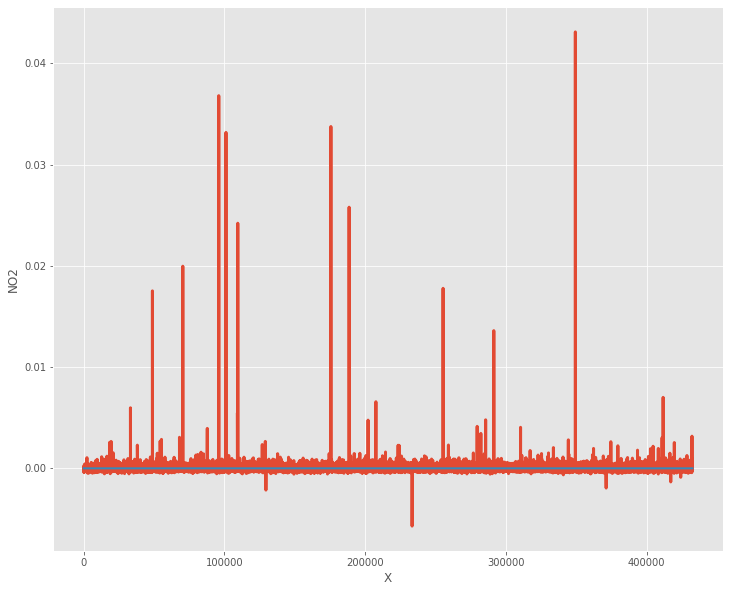

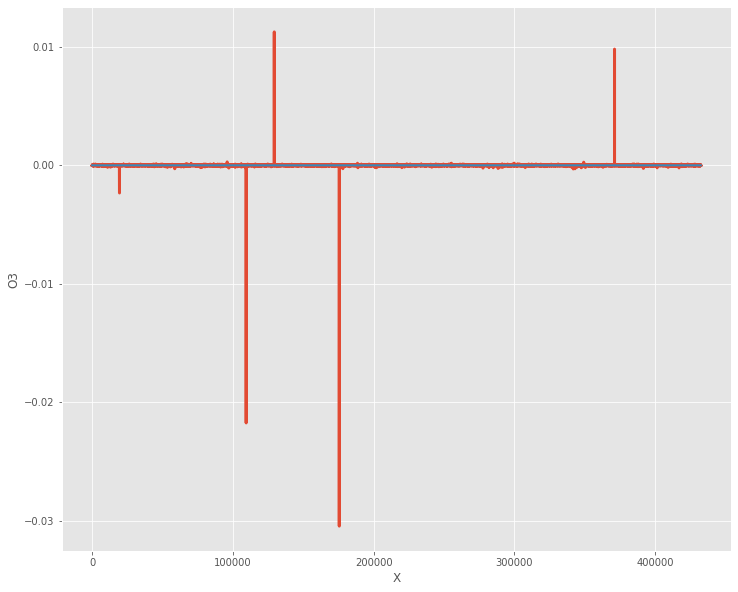

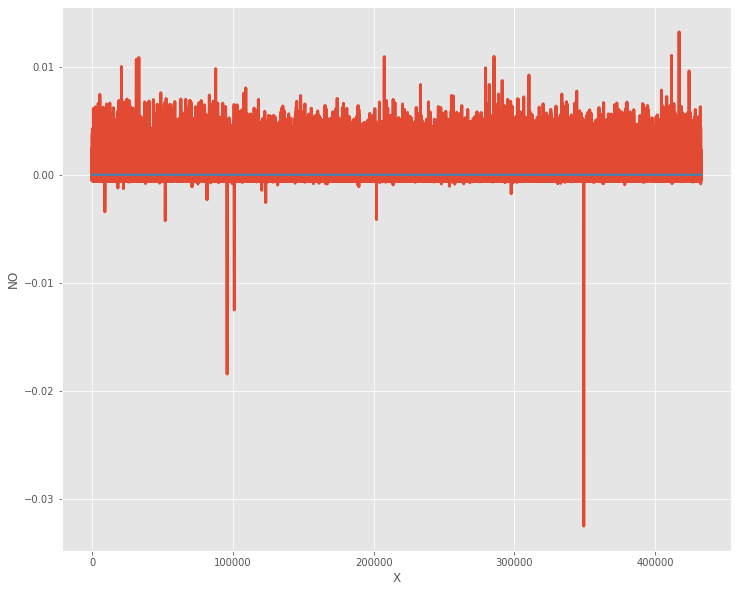

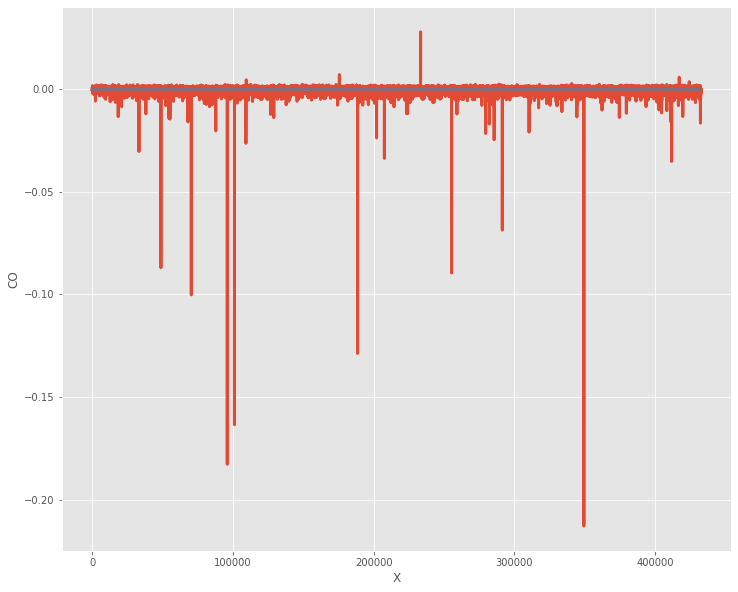

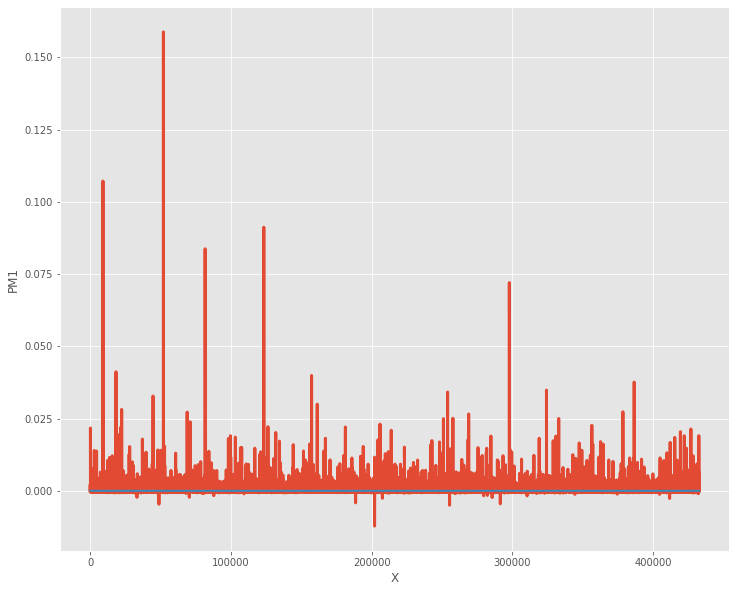

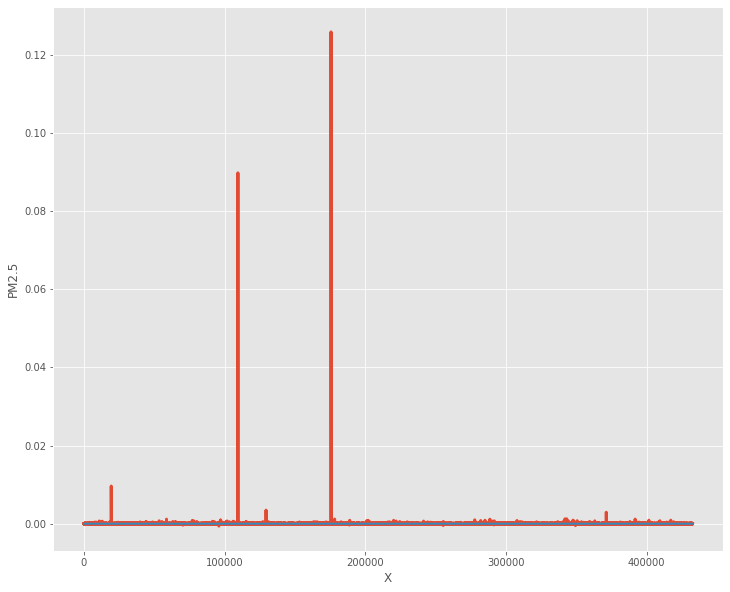

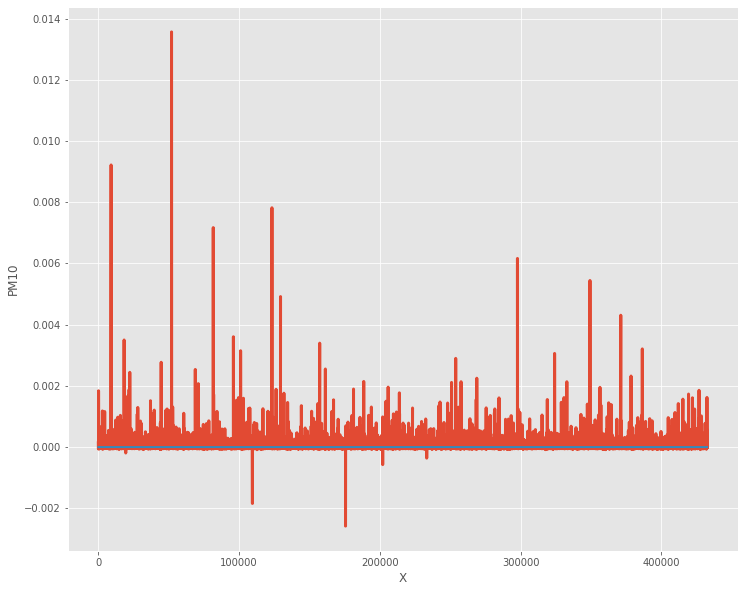

In [7]:
# printing y_test and y_test_predict
print("Y_Test:",y_test)
print("Y_Test_Predict:",y_test_pred2)

from matplotlib import style

style.use('ggplot')
for i in range(0,7):
  plt.figure(figsize=[12,10])
  plt.plot(y_test[:,i],linewidth=3, markersize=12)
  plt.plot(y_test_pred2[:,i],linewidth=2, markersize=12)
  plt.xlabel('X')
  plt.ylabel(train_sizes[i])
  plt.show()

In [ ]:
#completed